In [1]:
'''

#Enable GPU for this Exercise.

'''

'\n\n#Enable GPU for this Exercise.\n\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset, random_split


# This package is helpful to apply noise to our images
import skimage

#If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


'''
Import Mnist
'''

batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

len(mnist_trainset)
len(mnist_testset)




'''
Normalize each input from [0.0,1.0] range
'''
#transforming with ToTensor() will normalize the data for me


'''
Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''
X_train = mnist_trainset.data
y_train = mnist_trainset.targets

X_test = mnist_testset.data
y_test = mnist_testset.targets

val_size = 5000
test_size = 5000

# valset, testset = random_split(X_test, [val_size, test_size])

#add dimention in the 1 spot for batch size
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)



print(X_train.shape)
print(X_test.shape)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


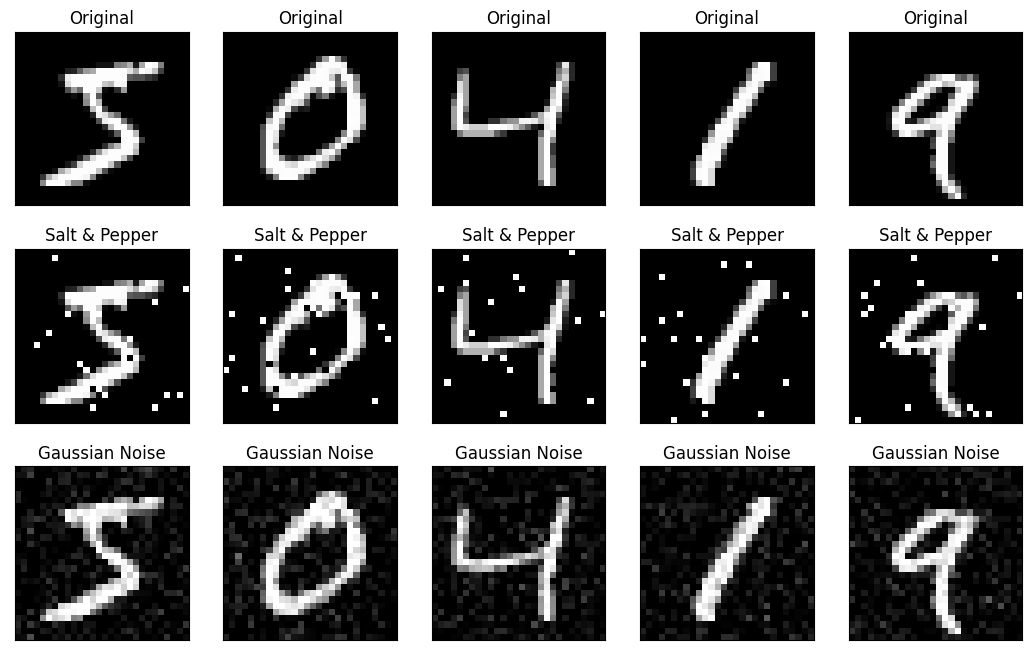

In [70]:
#before
plt.figure(figsize=(13,8))

num_examples = 5

for i in range(num_examples):
    plt.subplot(3, num_examples, i+1)
    plt.imshow(X_train[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Original')

# create your training sets (X_train_GN) and (X_train_SP)


#Salt and pepper



X_train_SP = skimage.util.random_noise(X_train, mode='s&p', amount=0.05)
X_test_SP = skimage.util.random_noise(X_test, mode='s&p', amount=0.05)

for i in range(num_examples):
    plt.subplot(3, num_examples, i+6)
    plt.imshow(X_train_SP[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Salt & Pepper')

#Gaussian Noise

X_train_GN = skimage.util.random_noise(X_train, mode='gaussian')

for i in range(num_examples):
    plt.subplot(3, num_examples, i+11)
    plt.imshow(X_train_GN[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Gaussian Noise')

In [96]:
'''
Create the arquitecture 

'''

class Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super(Autoencoder, self).__init__()
        # you can use sequential of not 

        max_filter = 16

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=int(max_filter/2), kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=int(max_filter/2), out_channels=max_filter, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(start_dim=1),
            nn.Linear(max_filter*7*7, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, encoded_space_dim),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoded_space_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 250),
            nn.ReLU(),
            nn.Linear(250, max_filter*7*7),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(max_filter,7,7)),
            # nn.Upsample(2, mode='nearest'),
            nn.ConvTranspose2d(in_channels=max_filter, out_channels=int(max_filter/2), kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # nn.Upsample(2, mode='nearest'),
            nn.ConvTranspose2d(in_channels=int(max_filter/2), out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print(x.shape)
        x = self.encoder(x)
        x = self.decoder(x)
        # print(x.shape)
        return x
    
    def train(self, train_data, test_loader, num_epochs, lr):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            total_loss = 0.0
            for X_in, y in train_data:
                corrupt_im, clean_im = X_in.to(device).float(), y.to(device).float()
                # inputs = inputs.squeeze(1).to(device)
                optimizer.zero_grad()
                # print(labels)
                outputs = self.forward(corrupt_im)

                loss = criterion(clean_im, outputs)
                # print(loss)
                loss.backward()
                optimizer.step()
                

            
            test_loss = 0.0
            with torch.no_grad():
                for X_in, y in test_loader:
                    test_inputs, test_images = X_in.to(device).float(), y.to(device).float()
                    test_outputs = self.forward(test_inputs)
                    test_loss += criterion(test_outputs, test_images).item()

            
    
                # Plot the progress
            if (epoch+1)%1 == 0:
                print(f"TRAIN Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.3f}")
                print(f"TEST Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.3f}")
                plt.figure(figsize=(10, 4))
                for i in range(5):
                    plt.subplot(2, 5, i + 1)
                    plt.imshow(test_inputs[i, 0].cpu().numpy(), cmap='gray')
                    plt.title(f'Original {i + 1}')
                    plt.axis('off')

                    plt.subplot(2, 5, i + 6)
                    plt.imshow(test_outputs[i][0].cpu().detach().numpy(), cmap='gray')
                    plt.title(f'Output {i + 1}')
                    plt.axis('off')

                plt.show()



    

In [71]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [94]:

'''
Define your training routine,
your optimizer, your loss function.
Everything you need to train the model
'''
encoded_space_dim = 32
batch_size = 128
lr = 0.001
num_epochs = 10

# train_loader_SP = torch.utils.data.DataLoader(X_train_SP.astype(np.float32), batch_size=batch_size)
# y_label_loader = torch.utils.data.DataLoader(y_train, batch_size=batch_size)

trainset_SP = CustomDataset(torch.tensor(X_train_SP.astype(np.float32)), X_train)
testset_SP = CustomDataset(torch.tensor(X_test_SP.astype(np.float32)), X_test)

train_loader_SP = torch.utils.data.DataLoader(trainset_SP, batch_size=batch_size)
test_loader_SP = torch.utils.data.DataLoader(testset_SP, batch_size=batch_size)
# look = trainset_SP.__getitem__(82)

# print(look[1])


TRAIN Epoch [1/10] Loss: 6029.705
TEST Epoch [1/10] Loss: 6029.705


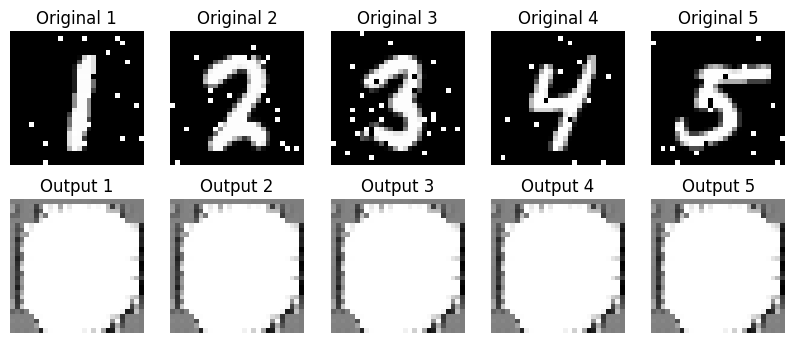

TRAIN Epoch [2/10] Loss: 6029.694
TEST Epoch [2/10] Loss: 6029.694


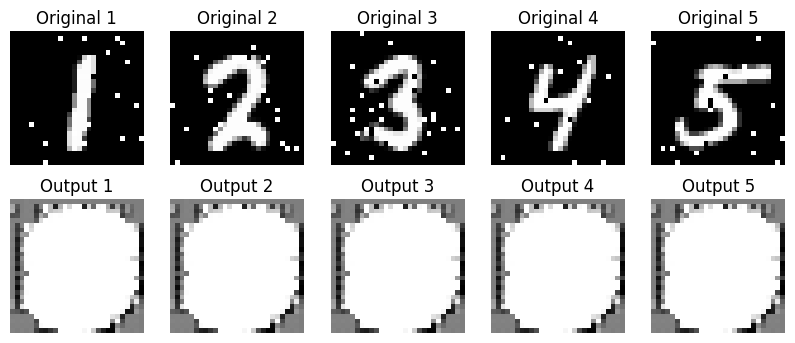

TRAIN Epoch [3/10] Loss: 6029.687
TEST Epoch [3/10] Loss: 6029.687


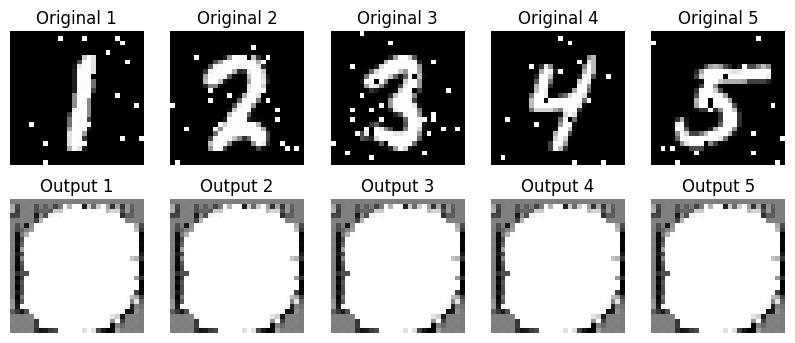

TRAIN Epoch [4/10] Loss: 6029.682
TEST Epoch [4/10] Loss: 6029.682


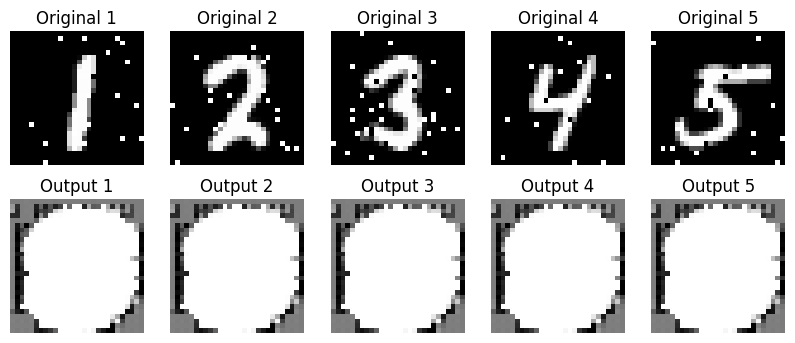

TRAIN Epoch [5/10] Loss: 6029.671
TEST Epoch [5/10] Loss: 6029.671


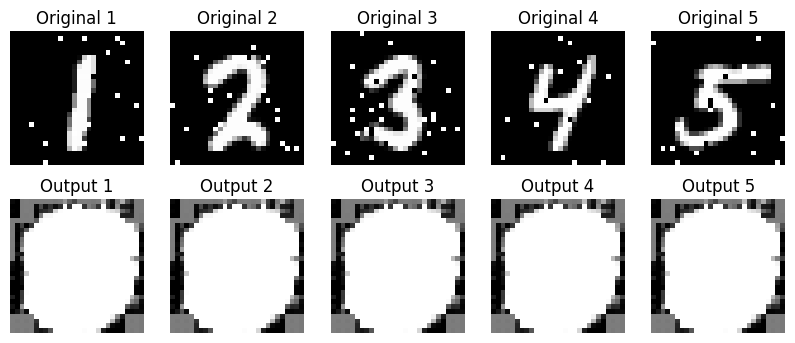

TRAIN Epoch [6/10] Loss: 6029.655
TEST Epoch [6/10] Loss: 6029.655


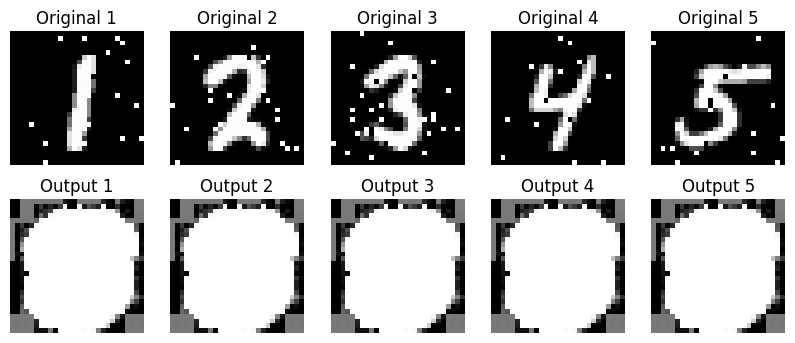

TRAIN Epoch [7/10] Loss: 6029.652
TEST Epoch [7/10] Loss: 6029.652


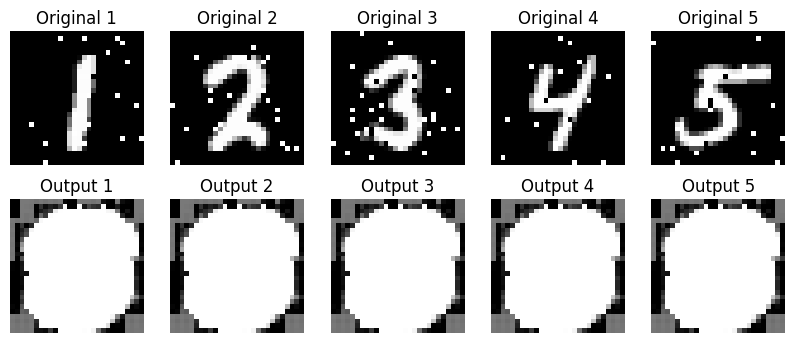

TRAIN Epoch [8/10] Loss: 6029.649
TEST Epoch [8/10] Loss: 6029.649


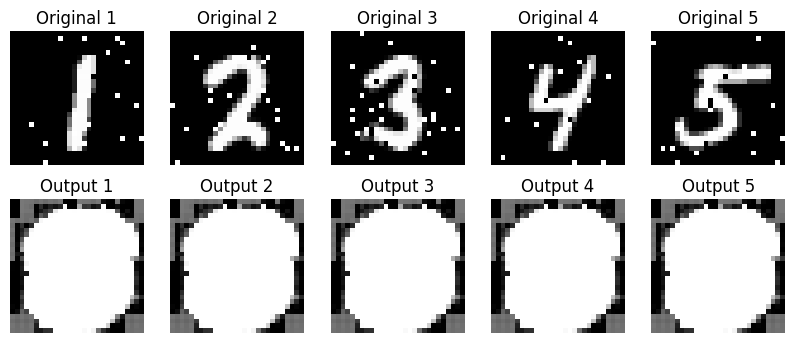

TRAIN Epoch [9/10] Loss: 6029.648
TEST Epoch [9/10] Loss: 6029.648


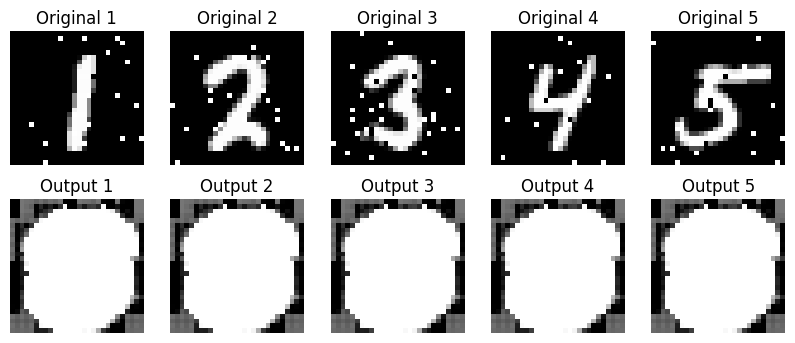

TRAIN Epoch [10/10] Loss: 6029.646
TEST Epoch [10/10] Loss: 6029.646


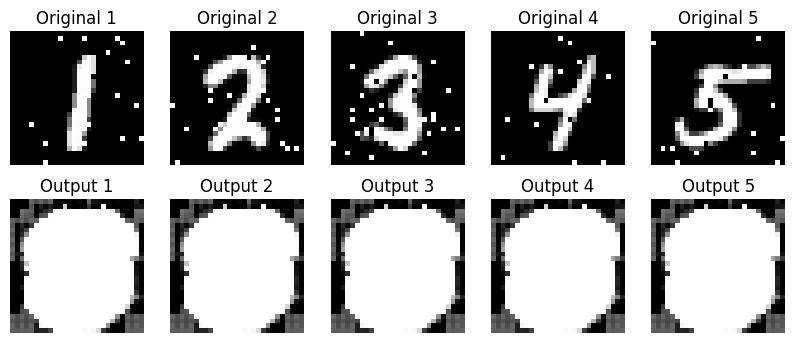

In [95]:
# define the netowrk to be train with the salt and peper corrupted images
# train the network
AutoNN_SP = Autoencoder(encoded_space_dim = encoded_space_dim).to(device)

AutoNN_SP.train(AutoNN_SP, train_loader_SP, test_loader_SP, num_epochs=num_epochs, lr=lr)


In [ ]:
# define the netowrk to be train with the gaussian corrupted images
# train the network 
AutoNN_GN = Autoencoder().to(device)

In [ ]:
# corrupt test images with Salt and peper, pass them through AutoNN_SP 
# plot the results 

In [ ]:
# corrupt test images with Gaussian noise, pass them through AutoNN_GN
# plot the results 